## Project: Deep Learning - Building an Image Classifier for Detecting Plant Diseases

---

## Problem Statement

Farmers often struggle to identify plant diseases early, which leads to significant crop losses and reduced yields. Early and accurate detection of plant diseases can enable timely interventions, targeted treatments, and improved agricultural productivity.  

The goal of this project is to build an **image classification model** using the **PlantVillage dataset** and **PyTorch** to automatically detect and classify plant diseases from leaf images.  

The model should be able to distinguish between healthy leaves and multiple disease categories (e.g., *Powdery Mildew, Rust, Leaf Spot*). By providing reliable disease classification, this solution can support farmers in making informed decisions, reducing losses, and ensuring better crop health and food security.  


## The Data

**PlantVillage Data Set**.  This contains thousands of labeled images of healthy and diseased plant leaves, together with disease classification labels.

The data set is freely available and can be accessed or downloaded from [Kaggle](https://www.kaggle.com/datasets/mohitsingh1804/plantvillage).

The academic paper behind the data set is available [here](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2022.868926/full).

#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image

#### House keeping codes

- To create and manage folders

In [2]:
!kaggle datasets list -s mohitsingh1804/plantvillage

ref                          title               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------  ------------  ----------  --------------------------  -------------  ---------  ---------------  
mohitsingh1804/plantvillage  PlantVillage   857351099  2021-08-20 01:08:58.493000           7217         43  0.625            


In [3]:
nested_path = "data"
try:
    os.makedirs(nested_path, exist_ok=True)  
    print(f"Folder '{nested_path}' created successfully.")
except OSError as e:
    print(f"Error creating folder: {e}")

Folder 'data' created successfully.


In [4]:
#due to the size of the dataset, add data to git ignore so as to be able to upload to github
with open(".gitignore", "a") as f:
    f.write("data/\n")

#### Get the data

You can either download it to your machine and train a model there, or (recommended) connect the Kaggle data with a Google Colab notebook and train the model in the cloud, using a free GPU.  This will be _much_ quicker than running it locally on your machine.

In [6]:
# Put code for getting data from Kaggle here

path = "data"           

# download + unzip into  folder
!kaggle datasets download -d mohitsingh1804/plantvillage -p "{path}" --unzip


^C
Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0




  0%|          | 0.00/818M [00:00<?, ?B/s]
 10%|9         | 81.0M/818M [00:00<00:00, 846MB/s]
 22%|##1       | 176M/818M [00:00<00:00, 932MB/s] 
 34%|###4      | 278M/818M [00:00<00:00, 994MB/s]
 46%|####5     | 373M/818M [00:00<00:00, 948MB/s]
 57%|#####6    | 464M/818M [00:00<00:00, 380MB/s]
 69%|######9   | 565M/818M [00:01<00:00, 493MB/s]
 83%|########3 | 681M/818M [00:01<00:00, 631MB/s]
 94%|#########4| 771M/818M [00:01<00:00, 389MB/s]
100%|##########| 818M/818M [00:01<00:00, 513MB/s]


### 2. Data Preprocessing and Transformation

* Resized all images to 224x224 pixels to match the input size expected by the **ResNet18** model

* Applied random horizontal flipping to augment the data. Adding random horizontal flips helps generalize the model to real-world variations, such as flipped leaf images.

* Convert the images to PyTorch tensors.

* Normalize the image pixel values to match the pre-trained **ResNet**'s expected input distribution.


#### Transformation


In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Paths to data (Directory)

In [29]:
# Define data directories
data_dir = 'data/PlantVillage'

When training deep learning models, **batching** and **shuffling** help with computational efficiency and generalization.

#### Batching

Batching refers to dividing the data set into smaller subsets (or "batches") instead of processing the entire data set at once. This improves computational efficiency and training speed.

For example, if the data set has 1,000 samples and the batch size is 32, then:

- **1st Batch**: Samples 1–32
- **2nd Batch**: Samples 33–64
- ...
- **Last Batch (number 32)**: Samples 993–1,000

Each batch is passed through the model independently. After processing a batch, the gradients are computed and the model weights are updated. This process is repeated for every batch in an **epoch** (one complete iteration over the entire data set).

In `pytorch`, the `DataLoader` class automatically divides the data set into batches. The batch size (e.g., batch_size=32) specifies how many samples are in each batch.

#### Shuffling

Shuffling refers to randomly reordering the data set at the start of each epoch. This ensures that the model does not learn any unintended patterns or biases caused by the order of the data.

When `shuffle=True` is specified in the `DataLoader` class, the data set is randomly reordered before creating batches.

Using the `DataLoader` class from `pytorch` to:
* Divide the training and validation sets into batches of 32 images
* Shuffle the training set only

#### Setting Dataloaders for batching and shuffling

##### Data loaders

In [31]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


In [32]:
# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 43444, 'val': 10861}

In [33]:
# Get class names
class_names = image_datasets['train'].classes
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [34]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3. Initialise the Model


Using a pre-trained **ResNet18** model. **ResNet18** is a popular convolutional neural network (CNN) with 18 layers, pre-trained on [ImageNet](https://www.image-net.org/).  (For more information on ImageNet, see [here](https://en.wikipedia.org/wiki/ImageNet).)


In [35]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)


In [36]:
# Freeze all layers except the final one
for param in model.parameters():
    param.requires_grad = False

In [37]:
#  number of features in the final layer
num_ftrs = model.fc.in_features

In [38]:
# Replacing final layer to match PlantVillage classes

model.fc = nn.Linear(num_ftrs, len(class_names))

In [39]:
model = model.to(device)

#### Define the loss function


In [40]:
# loss function
criterion = nn.CrossEntropyLoss()


In [41]:
# Define optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [46]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### 4. Train the Model

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model




In [48]:
# Train the model# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 1.1116 Acc: 0.7123
val Loss: 0.4601 Acc: 0.8661

Epoch 1/9
----------
train Loss: 0.6758 Acc: 0.8039
val Loss: 0.3585 Acc: 0.8867

Epoch 2/9
----------
train Loss: 0.6040 Acc: 0.8184
val Loss: 0.3275 Acc: 0.8967

Epoch 3/9
----------
train Loss: 0.5652 Acc: 0.8273
val Loss: 0.2939 Acc: 0.9080

Epoch 4/9
----------
train Loss: 0.5447 Acc: 0.8326
val Loss: 0.3262 Acc: 0.8963

Epoch 5/9
----------
train Loss: 0.5320 Acc: 0.8383
val Loss: 0.3222 Acc: 0.8994

Epoch 6/9
----------
train Loss: 0.5209 Acc: 0.8408
val Loss: 0.3019 Acc: 0.9031

Epoch 7/9
----------
train Loss: 0.4729 Acc: 0.8540
val Loss: 0.2511 Acc: 0.9195

Epoch 8/9
----------
train Loss: 0.4763 Acc: 0.8537
val Loss: 0.2448 Acc: 0.9204

Epoch 9/9
----------
train Loss: 0.4681 Acc: 0.8564
val Loss: 0.2487 Acc: 0.9203

Training complete in 536m 36s
Best val Acc: 0.920449


### 5. Evaluate the Model (model validation)


In [49]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.83      0.89      0.86       126
                                 Apple___Black_rot       0.90      0.97      0.93       125
                          Apple___Cedar_apple_rust       1.00      0.87      0.93        55
                                   Apple___healthy       0.96      0.90      0.93       329
                               Blueberry___healthy       0.91      0.98      0.94       300
          Cherry_(including_sour)___Powdery_mildew       0.98      0.92      0.95       210
                 Cherry_(including_sour)___healthy       0.93      0.97      0.95       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.76      0.75      0.75       103
                       Corn_(maize)___Common_rust_       0.99      0.95      0.97       239
               Corn_(maize)___Northern_Leaf_Blight      

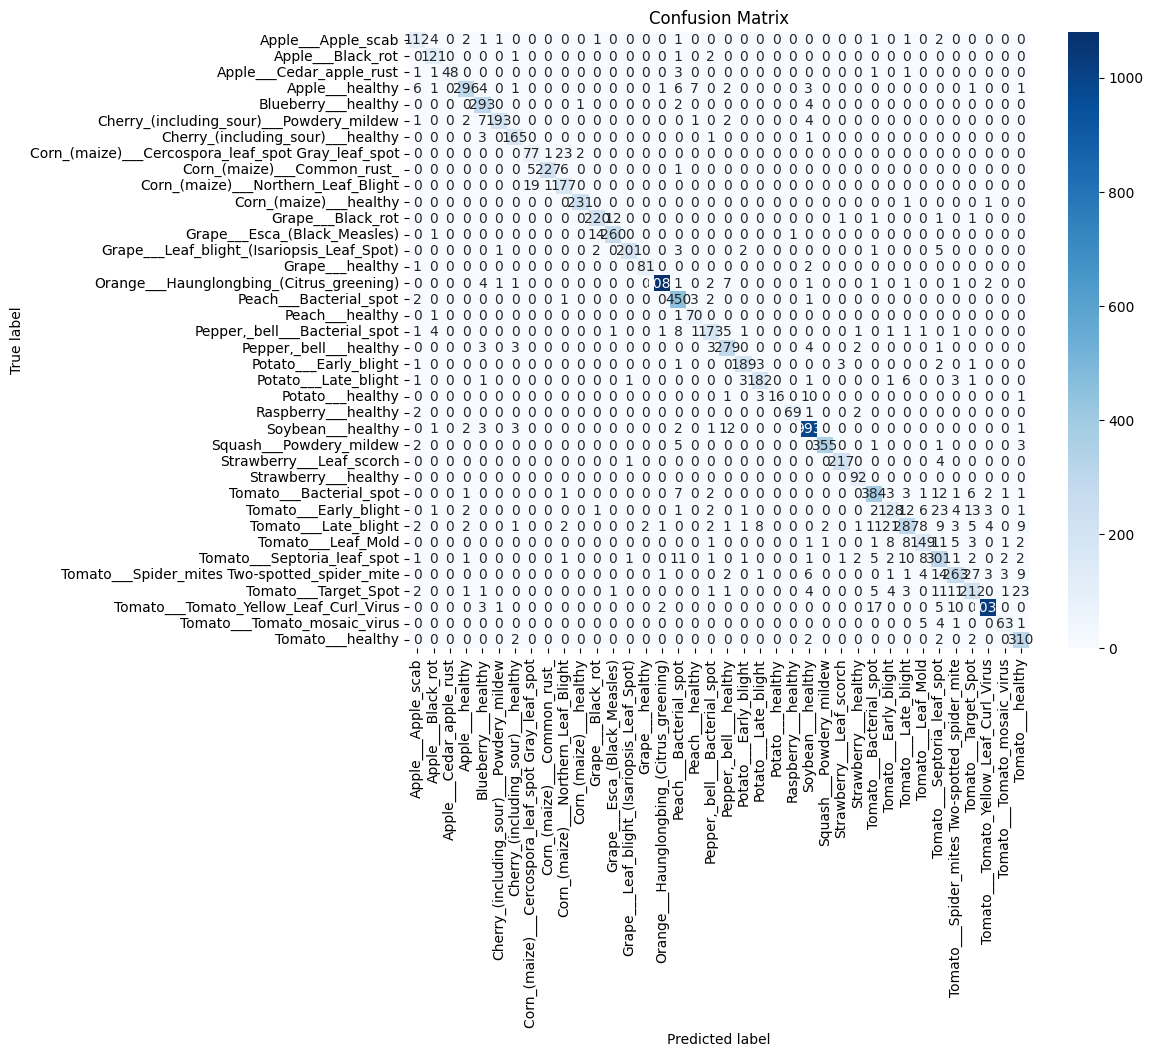

In [50]:
# Evaluating on validation set
evaluate_model(model, dataloaders['val'], class_names)

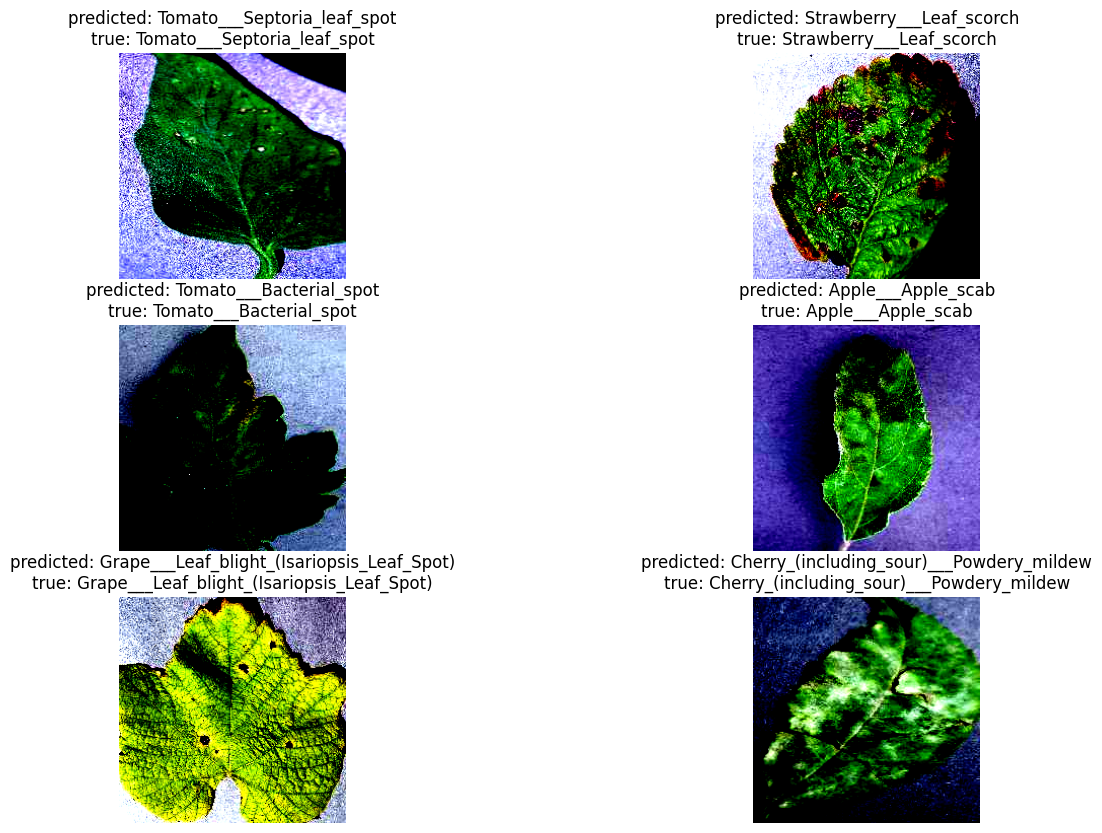

In [51]:
##visualization

def visualize_predictions(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                plt.imshow(img)
                
                if images_so_far == num_images:
                    return
        plt.tight_layout()

visualize_predictions(model)

### 6. Conclusions and Recommendations

# Model Performance Summary

**Overall Accuracy:** 92% on the validation set (10,861 images)  
**Macro F1-score:** ~0.90  
**Weighted F1-score:** ~0.92  

---

## Strongest Performing Classes  
(Precision & Recall > 0.95)

- **Orange___Haunglongbing (Citrus greening)** – F1 = 0.99  
- **Soybean___healthy** – F1 = 0.97  
- **Squash___Powdery_mildew** – F1 = 0.98  
- **Grape___healthy** – F1 = 0.97  
- **Corn___healthy** – F1 = 0.99  
- **Tomato___Tomato_Yellow_Leaf_Curl_Virus** – F1 = 0.97


## Moderate to Weak Performing Classes  
(Precision or Recall < 0.80)

- **Potato___healthy** – Precision = 1.00, Recall = 0.52 → Many healthy potatoes misclassified.  
- **Tomato___Early_blight** – Precision = 0.76, Recall = 0.64 → Under-detection.  
- **Tomato___Target_Spot** – F1 = 0.76 → Balanced but low recall.  
- **Corn___Cercospora_leaf_spot Gray_leaf_spot** – F1 = 0.75.  
- **Tomato___Septoria_leaf_spot** – Precision = 0.74, Recall = 0.85 → High false positives.


## Observations

- **Class Imbalance:** Large classes like *Orange___Haunglongbing* (1,102 samples) dominate accuracy, masking weaker classes like *Potato___healthy* (31 samples).  
- **Error Patterns:** Most confusions occur between visually similar diseases (e.g., tomato blights).  
- **Recall Risks:** Some classes sacrifice recall for precision, risking missed detections in the field.

## Recommendations

1. **Augment Minority Classes** – Especially *Potato___healthy* and *Tomato___Early_blight*.  
2. **Targeted Augmentation** – Simulate varied lighting, angles, and partial leaves.  
3. **Threshold Tuning** – Adjust decision thresholds to balance precision and recall for critical diseases.  